In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv('C:/Users/shyam/Downloads/Data1.csv', parse_dates=[0])

In [18]:
df.describe()

,Sales,Inflation
count,177.000000,177.000000
mean,100.560956,2.258188
std,8.287005,1.551097
min,88.261600,-0.589731
25%,94.500610,1.451779
50%,99.111710,2.006857
75%,106.215700,2.646380
max,119.518000,9.657443


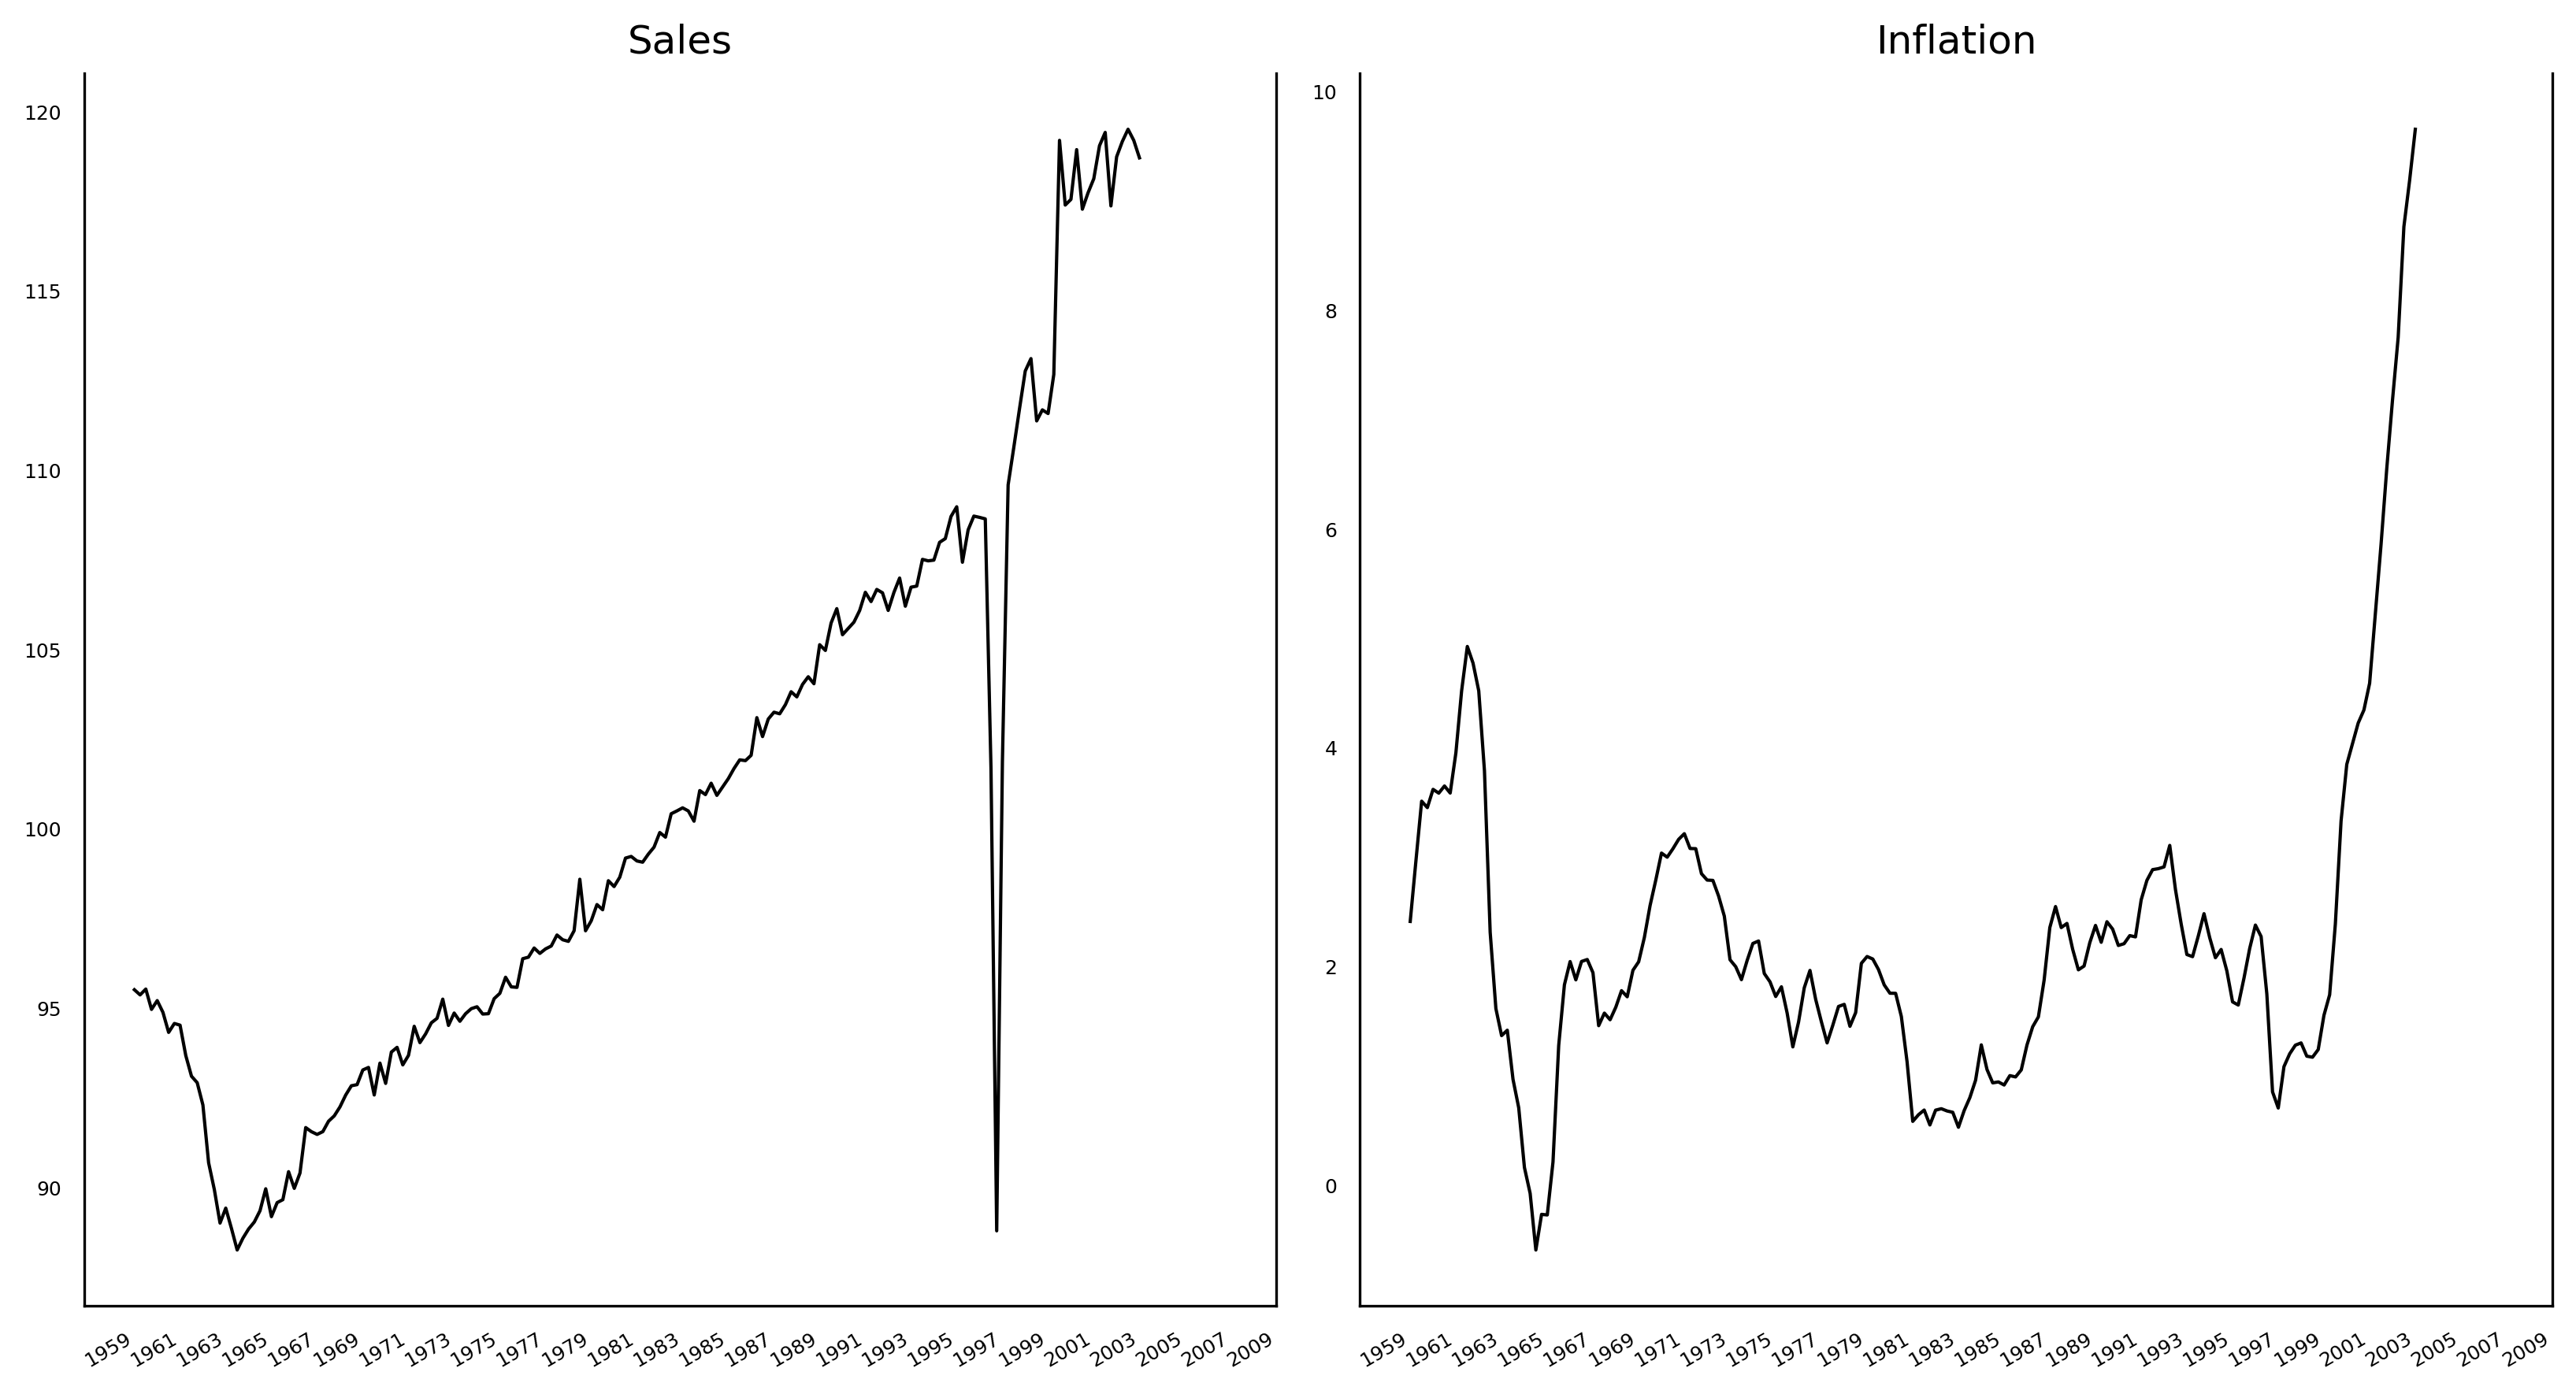

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=2, dpi=300, figsize=(11,6))
 
for i, ax in enumerate(axes.flatten()[:2]):
    data = df[df.columns[i+1]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(df.columns[i+1])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
 
plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()

In [13]:
from statsmodels.tsa.stattools import adfuller

target = df['Sales']
exog = df[['Inflation']]
 
ad_fuller_result = adfuller(target)
 
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.6065671963190327
p-value: 0.9877763856555005


In [14]:
target_diff = target.diff()
 
ad_fuller_result = adfuller(target_diff[1:])
 
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -9.240279199169045
p-value: 1.5894197106745656e-15


In [15]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [16]:
def optimize_SARIMAX(endog: Union[pd.Series, list] , exog: Union[pd.Series, list], order_list: list, d: int, D: int,  s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [17]:
p = range(0, 2, 1)
d = 1
q = range(0, 2, 1)
P = range(0, 2, 1)
D = 1
Q = range(0, 2, 1)
s = 12
 
from itertools import product
parameters = product(p, q, P, Q)
parameters_list = list(parameters) 

In [19]:
target_train = target[:165]
exog_train = exog[:165]
 
result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

<ipython-input-16-b161305fb58e>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


,"(p,q,P,Q)",AIC
0,"(1, 1, 1, 1)",632.107830
1,"(1, 1, 0, 1)",632.519724
2,"(0, 0, 1, 1)",634.251812
3,"(0, 0, 0, 1)",635.833081
4,"(0, 1, 1, 1)",635.996123
5,"(1, 0, 1, 1)",636.161379
6,"(0, 1, 0, 1)",637.313488
7,"(1, 0, 0, 1)",637.651767
8,"(1, 1, 1, 0)",638.833916
9,"(0, 0, 1, 0)",642.839021


In [20]:
best_model = SARIMAX(target_train, exog_train, order=(1,1,1), seasonal_order=(1,1,1,12), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)
 
print(best_model_fit.summary())
#A Display the summary table of the model

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  165
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -310.054
Date:                            Fri, 23 Sep 2022   AIC                            632.108
Time:                                    15:21:15   BIC                            650.251
Sample:                                         0   HQIC                           639.478
                                            - 165                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Inflation      1.3530      0.591      2.289      0.022       0.195       2.511
ar.L1         -0.5513      0.267   

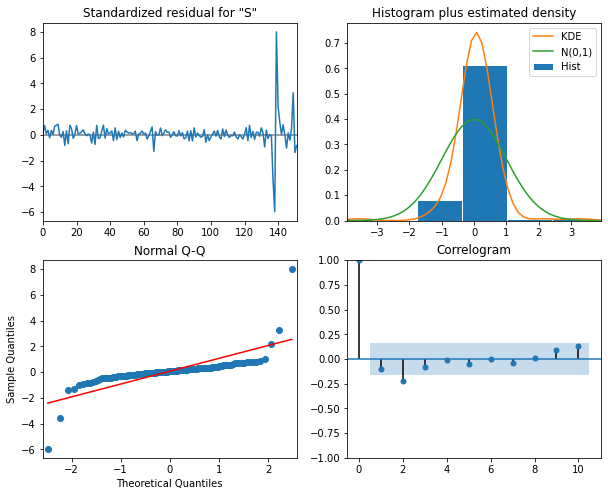

In [21]:
best_model_fit.plot_diagnostics(figsize=(10,8));

In [49]:
def recursive_forecast(endog: Union[pd.Series, list],  exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
 
    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(1,1,1), seasonal_order=(1,1,1,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX
            
    elif method=='SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model_a = SARIMAX(endog[:i], order=(1,1,1), seasonal_order=(1,1,1,12), simple_differencing=False)
            res_a = model_a.fit(disp=False)
            oos_pred_a = res_a.predict(-window)
            pred_SARIMA.extend(oos_pred_a)
            
        return pred_SARIMA
        
            
        

In [53]:
target_train = target[:166]
target_test = target[166:]
 
pred_df = pd.DataFrame({'actual': target_test})
 
TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1
 
pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMA= recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df.index=df['TIME'].iloc[-11:]
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMA'] = pred_SARIMA
pred_df['pred_SARIMAX'] = pred_SARIMAX
 
pred_df

C:\Users\shyam\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


,actual,pred_last_value,pred_SARIMA,pred_SARIMAX
TIME,,,,
2021-07-01,117.2895,118.9506,118.925873,117.944416
2021-08-01,117.7482,117.2895,119.023593,119.238332
2021-09-01,118.1388,117.7482,117.379537,117.558184
2021-10-01,119.0593,118.1388,118.178743,118.560111
2021-11-01,119.4310,119.0593,117.680003,118.562831
2021-12-01,117.3809,119.4310,119.698050,120.251050
2022-01-01,118.7502,117.3809,119.334553,120.107208
2022-02-01,119.1781,118.7502,117.136933,117.739326
2022-03-01,119.5180,119.1781,119.323024,119.985630


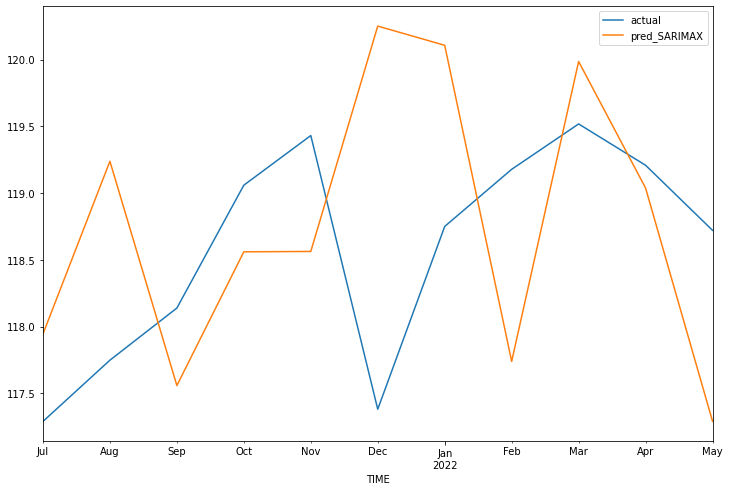

In [59]:
pred_df[['actual','pred_SARIMAX']].plot(figsize=(12,8))

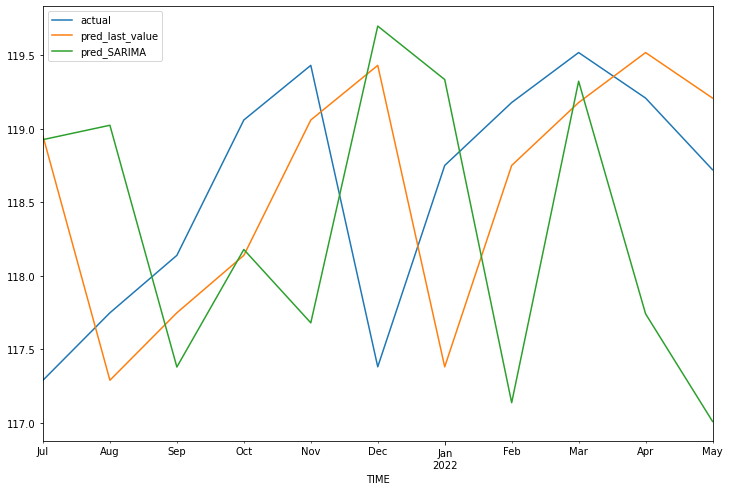

In [61]:
pred_df[['actual', 'pred_last_value','pred_SARIMA']].plot(figsize=(12,8))

In [ ]:
df['forecast_xreg']=results_xreg.predict(start=150,end=175,dynamic=True)
df['forecast_w']=results_w.predict(start=150,end=175,dynamic=True)
df['forecast_1']=results1.predict(start=150,end=175,dynamic=True)
df[['Sales','forecast_xreg','forecast_w','forecast_1']].plot(figsize=(12,8))

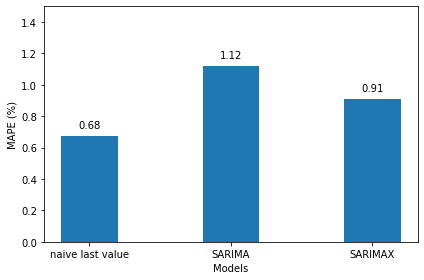

In [51]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMA=mape(pred_df.actual, pred_df.pred_SARIMA)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)
 
fig, ax = plt.subplots()
 
x = ['naive last value', 'SARIMA', 'SARIMAX']
y = [mape_last, mape_SARIMA, mape_SARIMAX]
 
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1.5)
 
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
 
plt.tight_layout()